# 災害データ分析レポート - Week10課題

## 課題概要
このノートブックでは、EM-DAT（国際災害データベース）のデータを使用して、自然災害の傾向を分析します。

### 実装内容
1. **自作のFunction（関数）**: 国別の災害トレンドを可視化する関数
2. **サンプル出力**: 関数を使用した日本の災害トレンド分析
3. **Loop（for文）**: 複数国の災害データを一括で分析・可視化

---

## 1. データの読み込みと前処理

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 日本語フォント設定（グラフで日本語を表示するため）
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

# データの読み込み
try:
    emdat = pd.read_csv('emdat.csv')
    print(f"OK データ読み込み成功: {len(emdat)}件のレコード")
    print(f"OK データ期間: {emdat['Start Year'].min():.0f}年 ~ {emdat['Start Year'].max():.0f}年")
except FileNotFoundError:
    print("エラー: 'emdat.csv'が見つかりません。")

# データの前処理
emdat['Total Deaths'] = emdat['Total Deaths'].fillna(0)
# 'Total Affected'列が存在しない場合は作成
if 'Total Affected' not in emdat.columns:
    emdat['Total Affected'] = 0
else:
    emdat['Total Affected'] = emdat['Total Affected'].fillna(0)
emdat = emdat.dropna(subset=['Start Year', 'Country'])
emdat['Start Year'] = emdat['Start Year'].astype(int)

# データの概要を表示
print(f"\n主要な災害タイプ:")
print(emdat['Disaster Type'].value_counts().head())

OK データ読み込み成功: 17278件のレコード
OK データ期間: 1900年 ~ 2024年

主要な災害タイプ:
Disaster Type
Flood                  6014
Storm                  4857
Earthquake             1624
Epidemic               1503
Mass movement (wet)     846
Name: count, dtype: int64


## 2. 自作Function: 国別災害トレンド分析関数

この関数は、指定した国の災害データを分析し、以下の情報を可視化します：
- 年別災害発生件数の推移
- 災害タイプ別の割合
- 総死者数と被災者数の統計

In [22]:
def analyze_disaster_by_country(country_name, data=emdat, start_year=1900, end_year=2024):
    """
    指定した国の災害データを分析し、可視化する関数
    
    Parameters:
    -----------
    country_name : str
        分析対象の国名
    data : DataFrame
        災害データ（デフォルト: emdat）
    start_year : int
        分析開始年（デフォルト: 1900）
    end_year : int
        分析終了年（デフォルト: 2024）
    
    Returns:
    --------
    dict : 統計情報の辞書
    """
    # 国データの抽出
    country_data = data[(data['Country'] == country_name) & 
                        (data['Start Year'] >= start_year) & 
                        (data['Start Year'] <= end_year)]
    
    if len(country_data) == 0:
        print(f"警告: {country_name}のデータが見つかりません")
        return None
    
    # 統計情報の計算
    total_disasters = len(country_data)
    total_deaths = country_data['Total Deaths'].sum()
    total_affected = country_data['Total Affected'].sum()
    
    # 可視化（2行2列のサブプロット）
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{country_name}の災害分析 ({start_year}-{end_year})', fontsize=16, fontweight='bold')
    
    # 1. 年別災害発生件数
    yearly_count = country_data['Start Year'].value_counts().sort_index()
    axes[0, 0].plot(yearly_count.index, yearly_count.values, marker='o', linewidth=2, markersize=4)
    axes[0, 0].set_title('年別災害発生件数', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('年')
    axes[0, 0].set_ylabel('発生件数')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 災害タイプ別割合
    disaster_types = country_data['Disaster Type'].value_counts()
    colors = plt.cm.Set3(range(len(disaster_types)))
    axes[0, 1].pie(disaster_types.values, labels=disaster_types.index, autopct='%1.1f%%', 
                   startangle=90, colors=colors)
    axes[0, 1].set_title('災害タイプ別割合', fontsize=12, fontweight='bold')
    
    # 3. 災害タイプ別発生件数（棒グラフ）
    disaster_types.plot(kind='barh', ax=axes[1, 0], color='steelblue')
    axes[1, 0].set_title('災害タイプ別発生件数', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('発生件数')
    axes[1, 0].set_ylabel('災害タイプ')
    
    # 4. 統計情報テキスト
    axes[1, 1].axis('off')
    stats_text = f"""
    【統計サマリー】
    
    ◆ 総災害発生件数: {total_disasters:,} 件
    
    ◆ 総死者数: {total_deaths:,.0f} 人
    
    ◆ 総被災者数: {total_affected:,.0f} 人
    
    ◆ 最多災害タイプ: {disaster_types.index[0]}
       ({disaster_types.values[0]}件)
    
    ◆ 分析期間: {start_year}-{end_year}
    
    ◆ 平均年間発生数: {total_disasters/(end_year-start_year+1):.1f} 件/年
    """
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報を辞書で返す
    return {
        'country': country_name,
        'total_disasters': total_disasters,
        'total_deaths': total_deaths,
        'total_affected': total_affected,
        'most_common_disaster': disaster_types.index[0],
        'disaster_types': disaster_types.to_dict()
    }

## 3. サンプル出力: 日本の災害トレンド分析

作成した関数を使用して、日本の災害データを分析します。

サンプル出力: 日本の災害分析


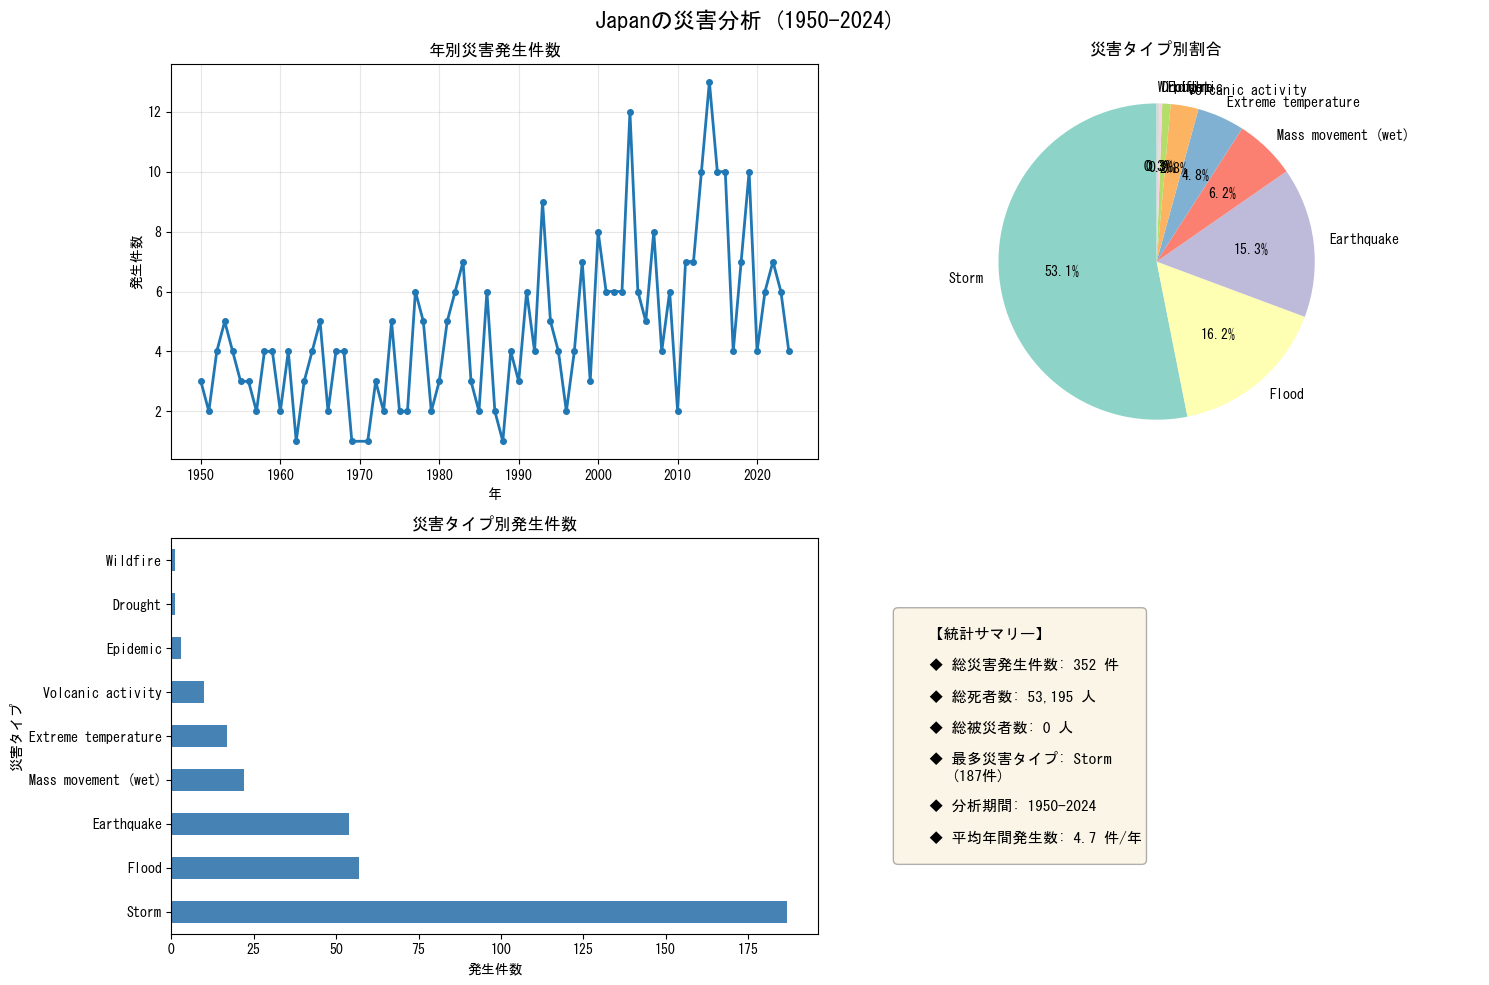


✓ 分析完了: Japan
  - 総災害件数: 352件
  - 最多災害: Storm


In [23]:
# 日本のデータを分析
print("="*60)
print("サンプル出力: 日本の災害分析")
print("="*60)

japan_stats = analyze_disaster_by_country('Japan', start_year=1950, end_year=2024)

if japan_stats:
    print(f"\n✓ 分析完了: {japan_stats['country']}")
    print(f"  - 総災害件数: {japan_stats['total_disasters']}件")
    print(f"  - 最多災害: {japan_stats['most_common_disaster']}")

### 日本の災害トレンドに関する考察

上記のグラフから、日本では以下の傾向が見られます：
- **経年変化**: 近年、災害報告件数が増加傾向にある
- **災害タイプ**: 地震、洪水、暴風などが主要な災害
- **地理的特性**: 環太平洋火山帯に位置することから、地震や火山活動による災害が多い

---

## 4. Loop（for文）による複数国の一括分析

for文を使用して、複数の国の災害データを一括で分析します。
ここでは、アジア太平洋地域の主要国を対象とします。

Loop処理: 複数国の災害分析
分析対象国: Japan, China, United States, Philippines, Indonesia


分析中: Japan


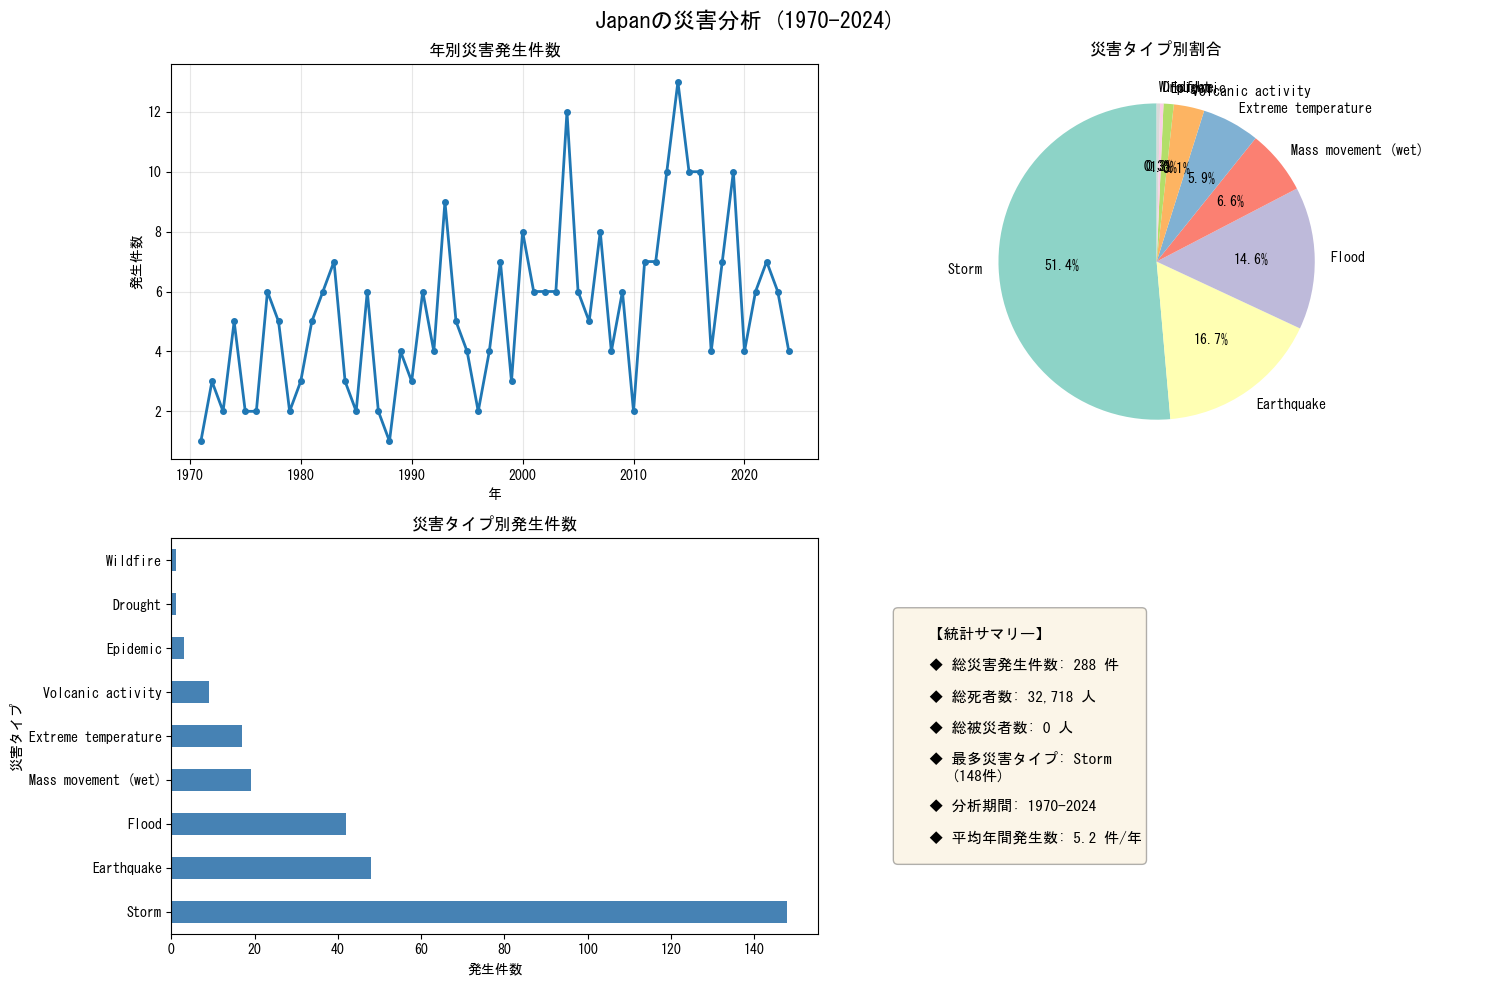


✓ Japanの分析完了

分析中: China


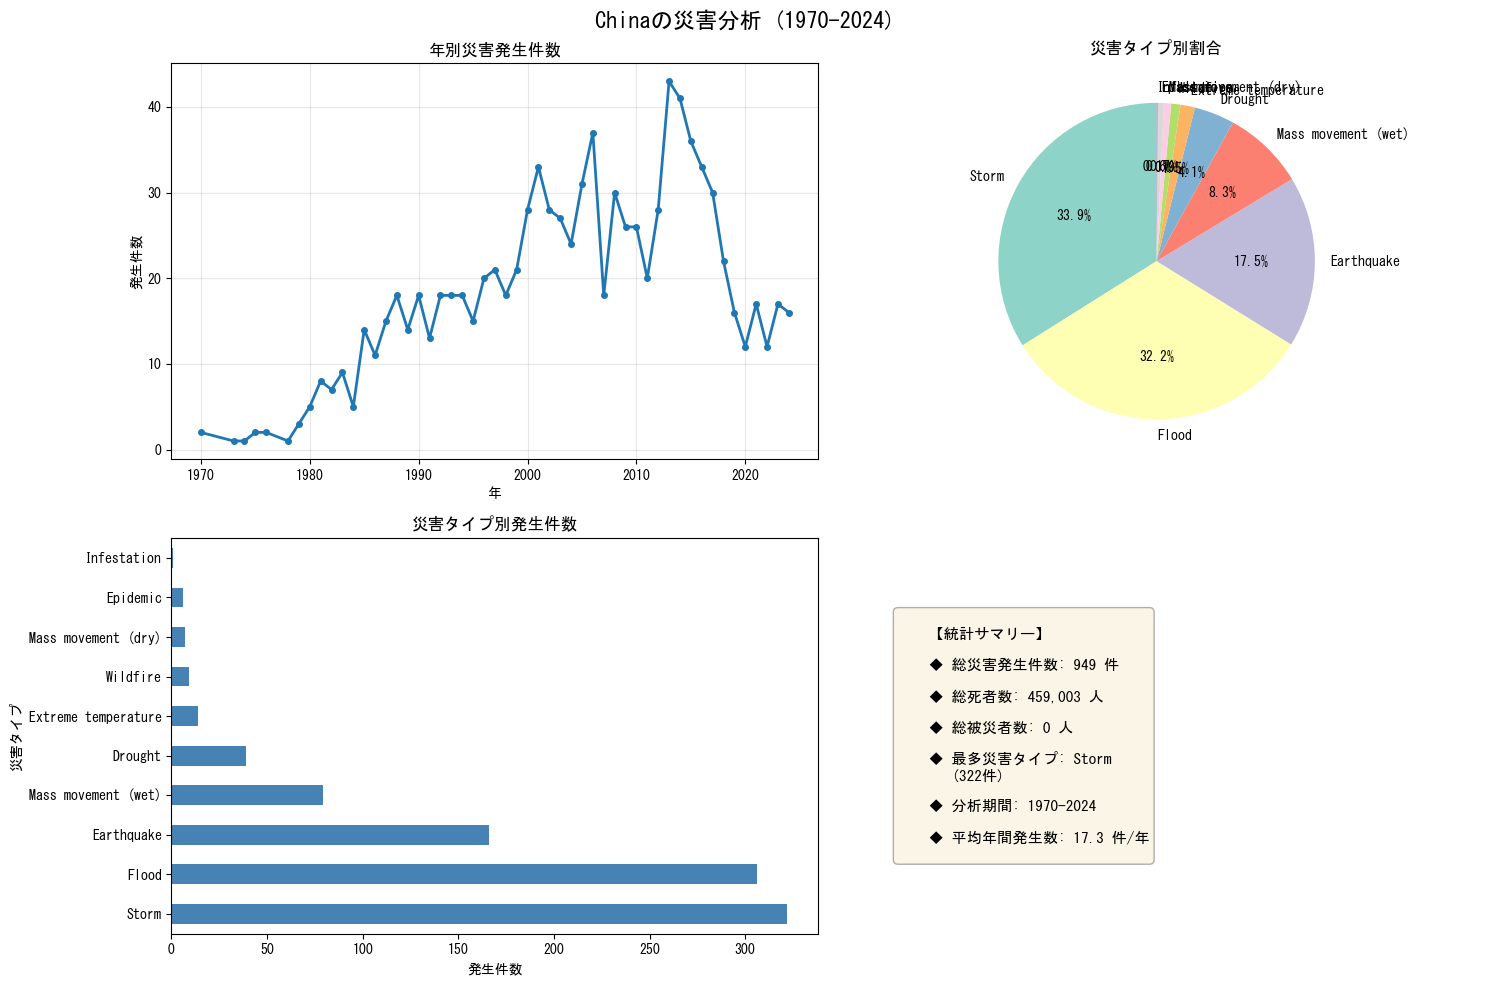


✓ Chinaの分析完了

分析中: United States
警告: United Statesのデータが見つかりません

分析中: Philippines


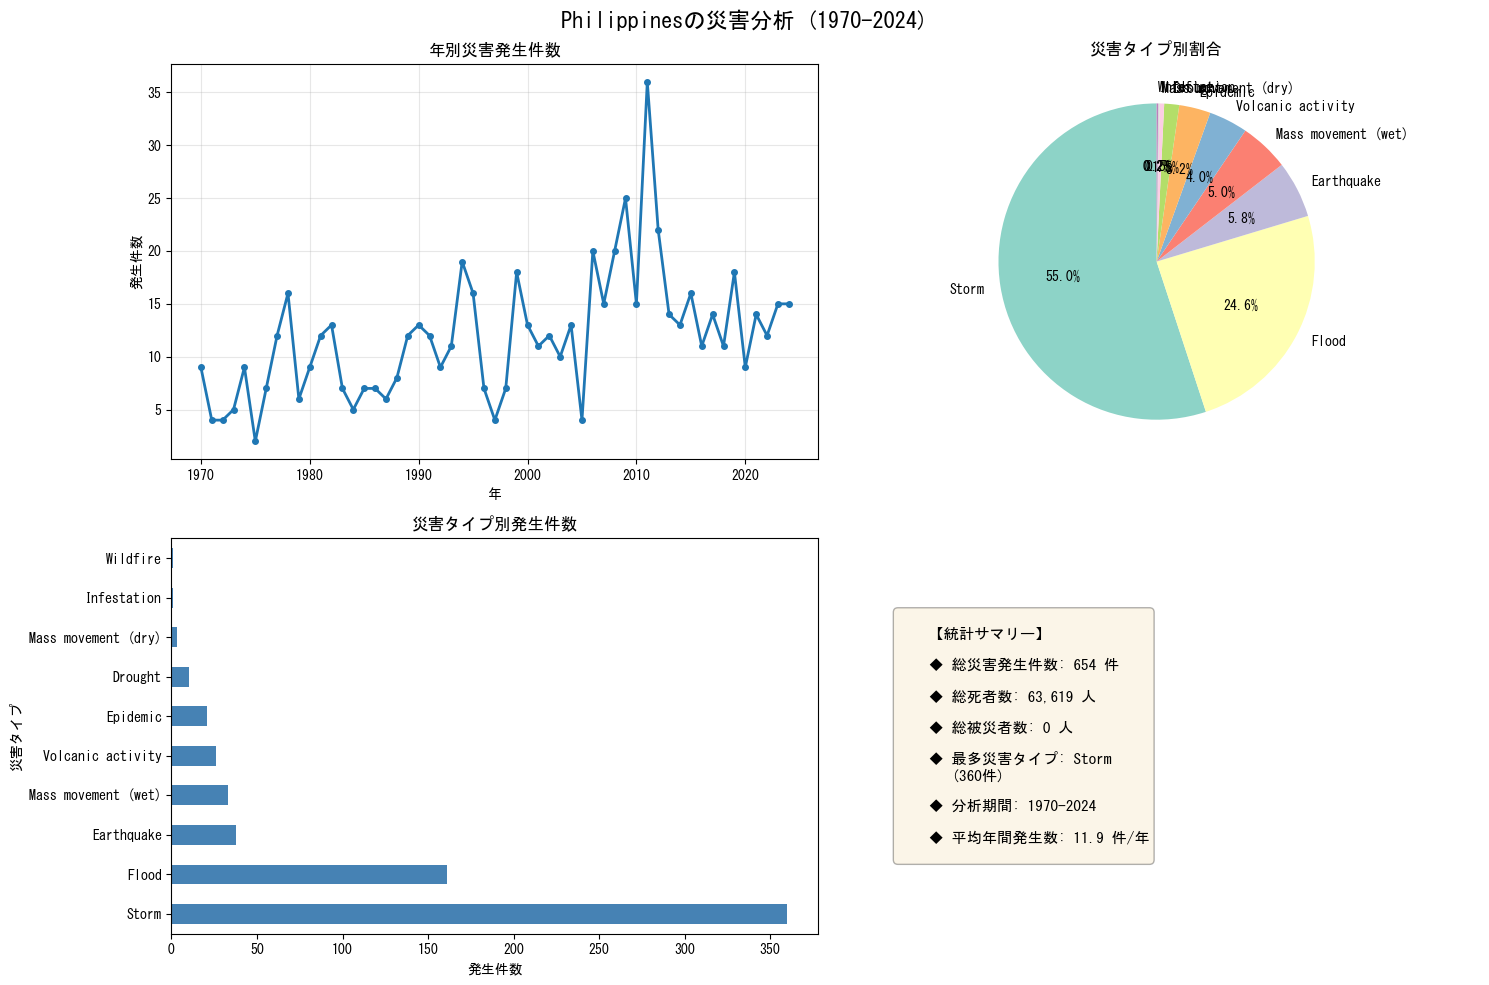


✓ Philippinesの分析完了

分析中: Indonesia


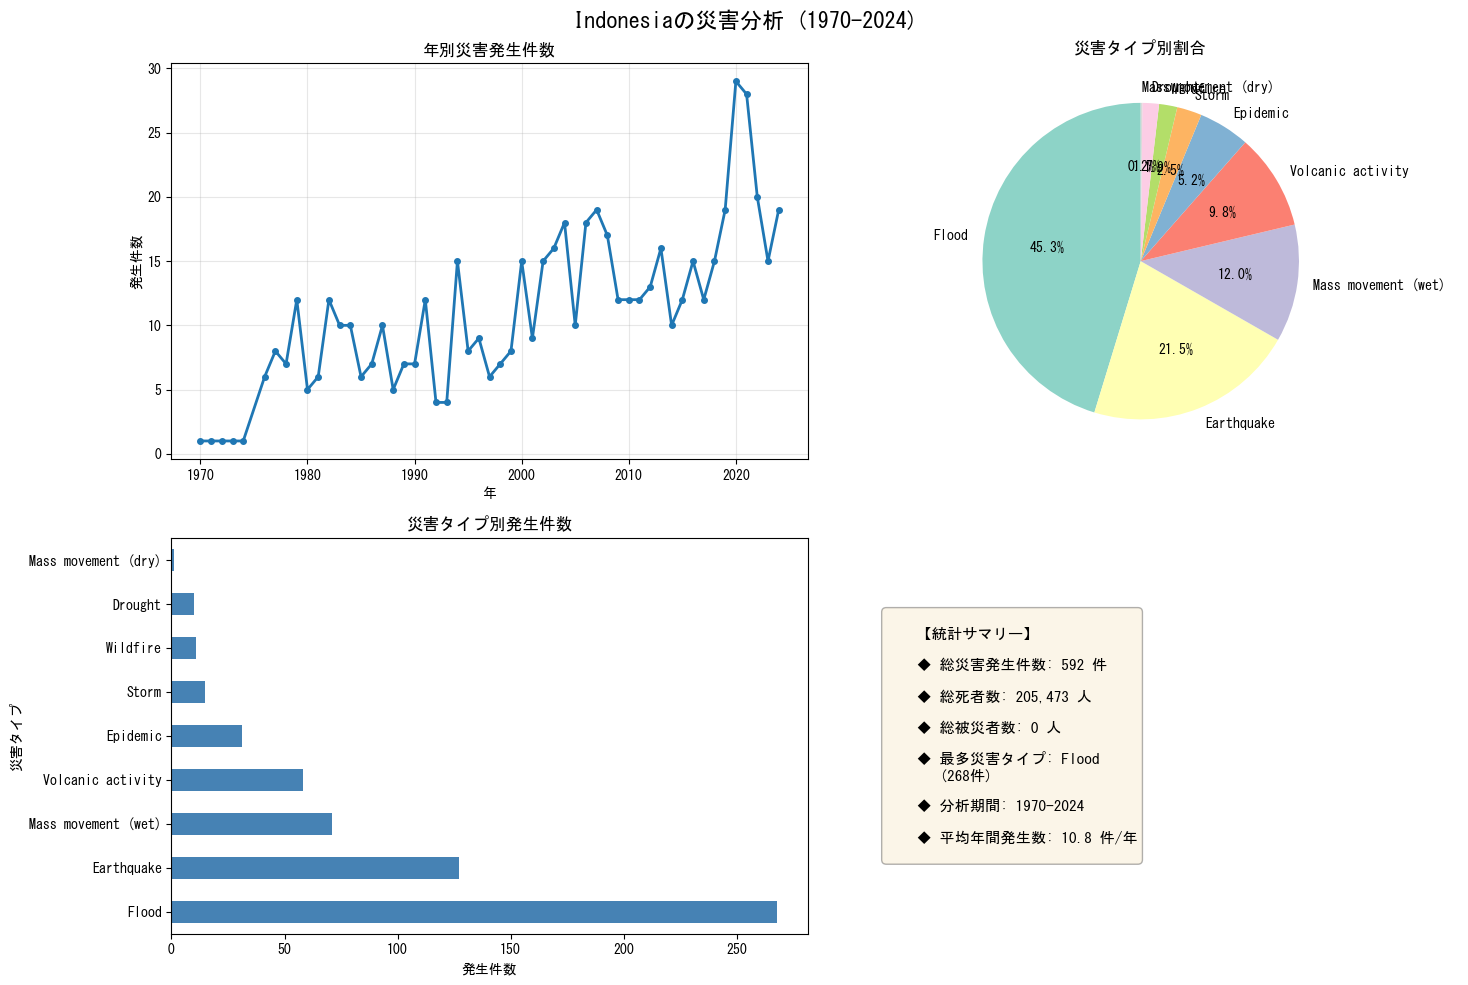


✓ Indonesiaの分析完了


In [24]:
# 分析対象国のリスト
target_countries = ['Japan', 'China', 'United States', 'Philippines', 'Indonesia']

print("="*60)
print("Loop処理: 複数国の災害分析")
print("="*60)
print(f"分析対象国: {', '.join(target_countries)}\n")

# 統計情報を保存するリスト
all_stats = []

# for文で各国を分析
for country in target_countries:
    print(f"\n{'='*60}")
    print(f"分析中: {country}")
    print(f"{'='*60}")
    
    # 関数を呼び出して分析
    stats = analyze_disaster_by_country(country, start_year=1970, end_year=2024)
    
    if stats:
        all_stats.append(stats)
        print(f"\n✓ {country}の分析完了")

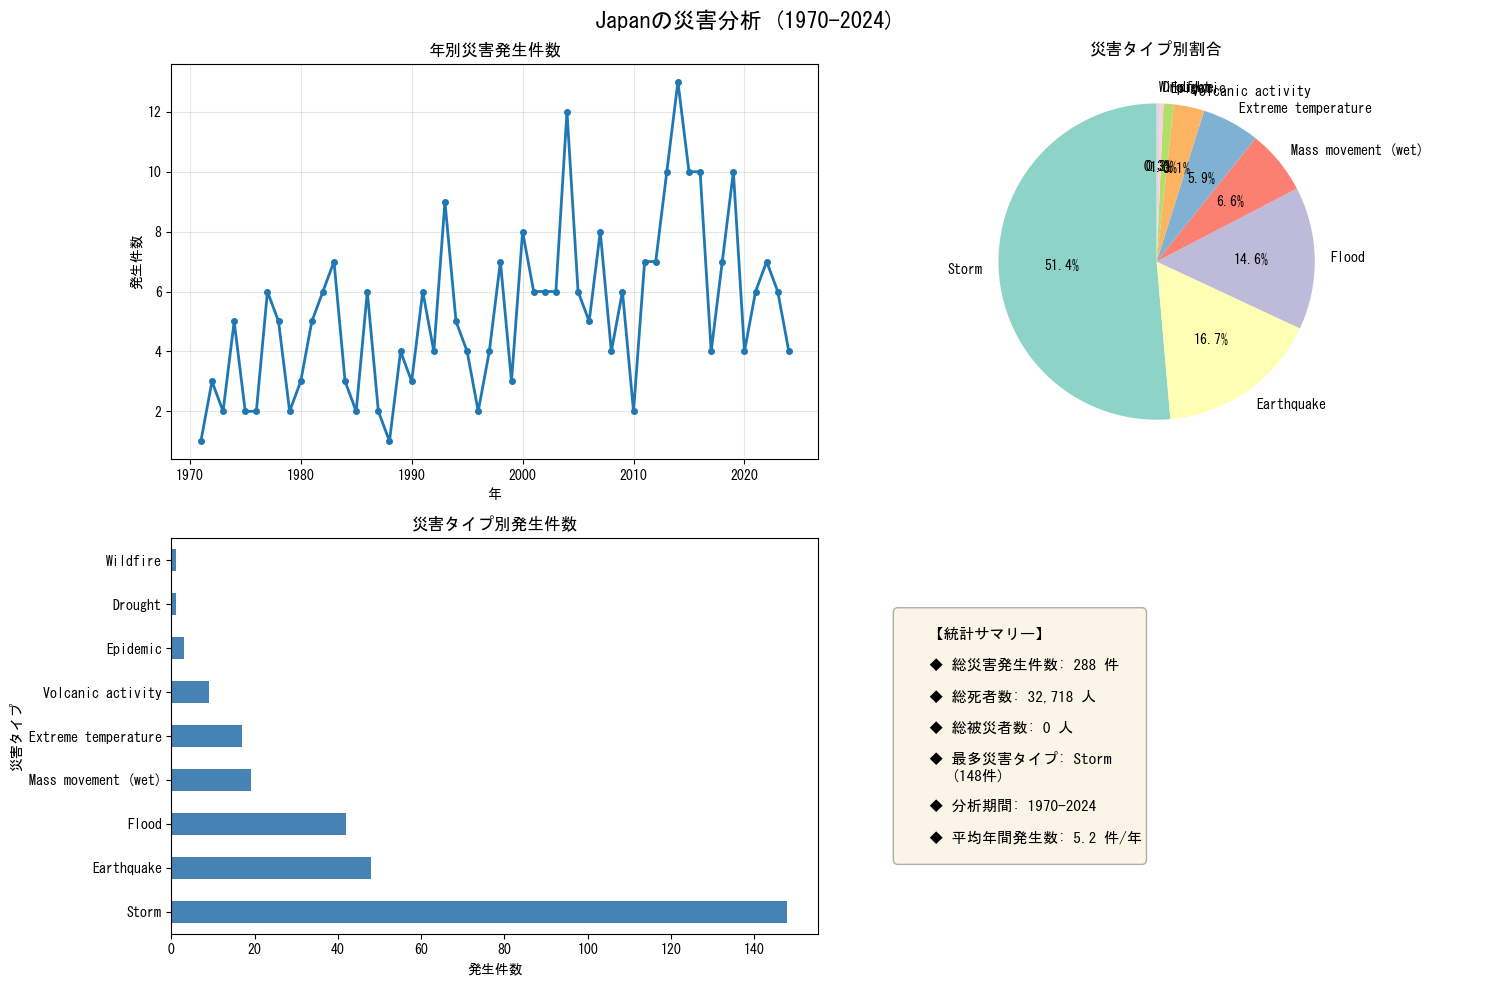

## 5. 国別比較: 統計サマリー

for文で収集したデータを使って、国別の比較分析を行います。


国別災害統計サマリー (1970-2024)
    country  total_disasters  total_deaths  total_affected most_common_disaster
      China              949      459003.0               0                Storm
Philippines              654       63619.0               0                Storm
  Indonesia              592      205473.0               0                Flood
      Japan              288       32718.0               0                Storm


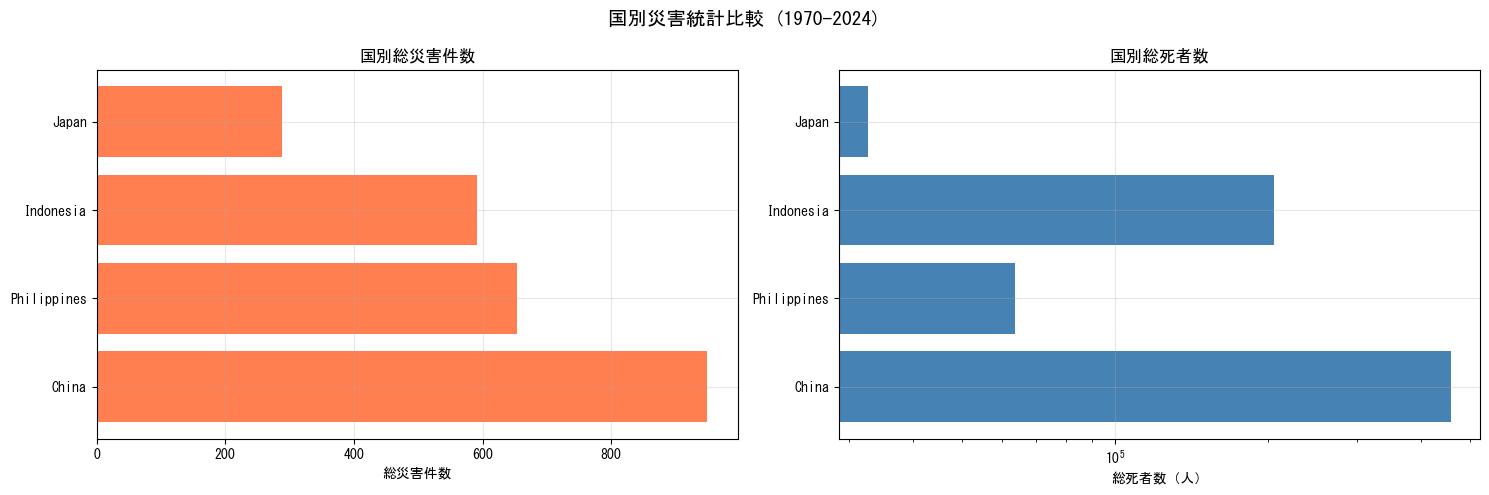

In [25]:
# 比較用データフレームの作成
if all_stats:
    comparison_df = pd.DataFrame(all_stats)
    comparison_df = comparison_df.sort_values('total_disasters', ascending=False)
    
    print("\n" + "="*80)
    print("国別災害統計サマリー (1970-2024)")
    print("="*80)
    print(comparison_df[['country', 'total_disasters', 'total_deaths', 'total_affected', 'most_common_disaster']].to_string(index=False))
    
    # 比較グラフの作成
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('国別災害統計比較 (1970-2024)', fontsize=14, fontweight='bold')
    
    # 総災害件数の比較
    axes[0].barh(comparison_df['country'], comparison_df['total_disasters'], color='coral')
    axes[0].set_xlabel('総災害件数')
    axes[0].set_title('国別総災害件数', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # 総死者数の比較（対数スケール）
    axes[1].barh(comparison_df['country'], comparison_df['total_deaths'], color='steelblue')
    axes[1].set_xlabel('総死者数（人）')
    axes[1].set_title('国別総死者数', fontweight='bold')
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("統計データが収集されていません。")

## 6. まとめと考察

### 実装された機能
✅ **自作Function**: `analyze_disaster_by_country()` - 国別災害分析関数  
✅ **サンプル出力**: 日本の災害データを詳細に分析  
✅ **Loop処理**: for文による5カ国の一括分析  

### 分析結果から得られた知見

1. **災害発生パターンの地域差**
   - アジア太平洋地域は、地震、台風、洪水などの自然災害が頻発
   - 各国で最多災害タイプが異なり、地理的特性を反映

2. **災害件数の経年変化**
   - 1970年代以降、報告件数が全体的に増加傾向
   - 気候変動の影響や、報告システムの改善が要因と考えられる

3. **人的被害の規模**
   - 国によって総死者数に大きな差がある
   - 防災インフラや早期警報システムの整備状況が影響

### 今後の課題
- より詳細な時系列分析（季節性、周期性の検討）
- 経済損失データの分析
- 地図上での可視化（foliumなどを使用）

---
